In [1]:
from collections import Counter
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

In [3]:
with open('poslo.txt') as f:
    lines = f.readlines()

In [7]:
lines[0]

'А где щи, тут и нас ищи.\n'

In [3]:
def preprocess(line):
    return ' '.join(w.lower() for w in (''.join(ch for ch in word if ch.isalpha()) for word in line.split()) if w)

In [2]:
preprocess(lines[0])

NameError: name 'lines' is not defined

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        lines,
    ):
        self.lines = lines
        self.pad_token = '<PAD>'
        self.bos_token = '<BOS>'
        self.eos_token = '<EOS>'
        self.uniq_words = [self.pad_token, self.bos_token, self.eos_token] + self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.pad_token_id = self.word_to_index['<PAD>']
        self.bos_token_id = self.word_to_index['<BOS>']
        self.eos_token_id = self.word_to_index['<EOS>']

        self.tokenized = [[self.word_to_index[w] for w in line.split()] for line in self.lines]

    def get_uniq_words(self):
        word_counts = Counter(word for line in self.lines for word in line.split())
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, index):
        return (
            torch.LongTensor([self.bos_token_id] + self.tokenized[index]),
            torch.LongTensor(self.tokenized[index] + [self.eos_token_id]),
        )

In [ ]:
dataset = Dataset([preprocess(line) for line in lines])

In [ ]:
dataset[0]

(tensor([  1,   4,  25, 310, 197,   5,  56, 311]),
 tensor([  4,  25, 310, 197,   5,  56, 311,   2]))

In [ ]:
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    xx_pad = pad_sequence(xx, batch_first=True, padding_value=dataset.pad_token_id)
    yy_pad = pad_sequence(yy, batch_first=True, padding_value=dataset.pad_token_id)

    return xx_pad, yy_pad, x_lens, y_lens

In [ ]:
dataloader = DataLoader(dataset, batch_size=512, collate_fn=pad_collate, shuffle=True)

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_len):
        super(Model, self).__init__()
        self.hidden_size = 256
        self.embedding_dim = 256
        self.num_layers = 3

        vocab_len = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=vocab_len,
            embedding_dim=self.embedding_dim,
            padding_idx=0,
        )
        self.rnn = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True,
        )
        self.fc = nn.Linear(self.hidden_size, vocab_len)

    def forward(self, x, lens=None, prev_state=None):
        embed = self.embedding(x)
        if lens is None:
            output, state = self.rnn(embed, prev_state)
        else:
            embed_packed = pack_padded_sequence(embed, lens, batch_first=True, enforce_sorted=False)
            output_packed, state = self.rnn(embed_packed, prev_state)
            output, _ = pad_packed_sequence(output_packed, batch_first=True)
        logits = self.fc(output)
        return logits, state

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(len(dataset.uniq_words)).to(DEVICE).train()

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

5319291

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
def train(model, dataloader, criterion, optimizer, epochs):
    losses = []
    model.train()

    for epoch in range(epochs):
        for x, y, x_lens, y_lens in dataloader:
            optimizer.zero_grad()

            y_pred, _ = model(x.to(DEVICE), x_lens)
            loss = criterion(y_pred.transpose(1, 2), y.to(DEVICE))

            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        if epoch % 10 == 0:
            print({ 'epoch': epoch, 'loss': losses[-1] })

    return losses

In [ ]:
loss_history = train(model, dataloader, criterion, optimizer, epochs=250)

{'epoch': 0, 'loss': 7.363110065460205}
{'epoch': 10, 'loss': 6.163822174072266}
{'epoch': 20, 'loss': 5.636088848114014}
{'epoch': 30, 'loss': 4.9511942863464355}
{'epoch': 40, 'loss': 4.465068340301514}
{'epoch': 50, 'loss': 3.9584920406341553}
{'epoch': 60, 'loss': 3.3800621032714844}
{'epoch': 70, 'loss': 2.950526714324951}
{'epoch': 80, 'loss': 2.472534656524658}
{'epoch': 90, 'loss': 2.3169844150543213}
{'epoch': 100, 'loss': 1.9929629564285278}
{'epoch': 110, 'loss': 1.849906086921692}
{'epoch': 120, 'loss': 1.7048944234848022}
{'epoch': 130, 'loss': 1.633349061012268}
{'epoch': 140, 'loss': 1.4937069416046143}
{'epoch': 150, 'loss': 1.4768993854522705}
{'epoch': 160, 'loss': 1.3624426126480103}
{'epoch': 170, 'loss': 1.3128288984298706}
{'epoch': 180, 'loss': 1.3424853086471558}
{'epoch': 190, 'loss': 1.2716399431228638}
{'epoch': 200, 'loss': 1.3160114288330078}
{'epoch': 210, 'loss': 1.2810907363891602}
{'epoch': 220, 'loss': 1.2134227752685547}
{'epoch': 230, 'loss': 1.27306

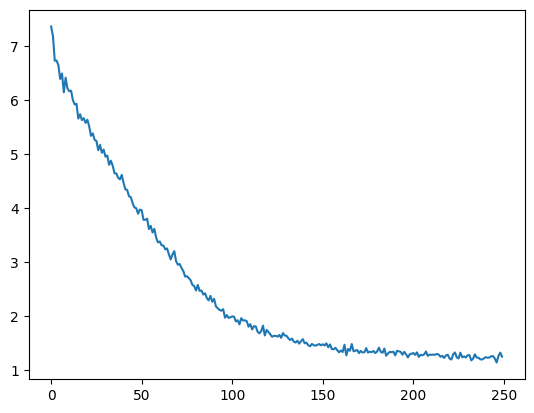

In [ ]:
plt.plot(loss_history)

In [ ]:
def tokenize(value):
    return [dataset.bos_token_id]+[dataset.word_to_index[word.lower()] for word in value.split()]


def decode(token_ids):
    return ' '.join(dataset.index_to_word[token_id] for token_id in token_ids)


@torch.no_grad()
def generate(prompt, max_tokens=20):
    model.eval()
    response = []
    state = None
    prompt_tokens = tokenize(prompt)
    model_input = torch.LongTensor([prompt_tokens]).to(DEVICE)
    for _ in range(max_tokens):
        logits, state = model(model_input, prev_state=state)
        token_argmax = logits[0, -1].argmax()
        response.append(token_argmax.item())
        if response[-1] == dataset.eos_token_id:
            break
        model_input = token_argmax.view(1, 1)

    return decode(prompt_tokens + response)

In [ ]:
generate('рука')

'<BOS> рука руку моет вор вора кроет <EOS>'

In [ ]:
@torch.no_grad()
def sample(prompt, max_tokens=20):
    model.eval()
    response = []
    state = None
    prompt_tokens = tokenize(prompt)
    model_input = torch.LongTensor([prompt_tokens]).to(DEVICE)
    for _ in range(max_tokens):
        logits, state = model(model_input, prev_state=state)
        token_probs = F.softmax(logits[0, -1], dim=-1).cpu().numpy()
        sampled_token = np.random.choice(len(token_probs), p=token_probs)
        response.append(sampled_token)
        if response[-1] == dataset.eos_token_id:
            break
        model_input = torch.LongTensor([[sampled_token]]).to(DEVICE)

    return decode(prompt_tokens + response)

In [ ]:
sample('без')

'<BOS> без копейки рубль щербатый <EOS>'

In [ ]:
!pip3 install --no-cache-dir transformers sentencepiece

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 1.4 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 282.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 KB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 KB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 864.5 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 KB 1.4 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  C

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruT5-large", use_fast=False)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
len(dataset.uniq_words)

7291

In [ ]:
len(set(((
    x for tokens in (
        tokenizer(
            preprocess(line),
            add_special_tokens=False,
        )['input_ids'] for line in lines
    ) for x in tokens
))))

4824